In [1]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

numpyro.set_host_device_count(
    1
)  # For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update(
    "jax_enable_x64", True
)
#jax.config.update('jax_disable_jit', True)

from jaxoplanet import light_curves, orbits
from jaxoplanet.light_curves import limb_dark_light_curve
import arviz as az
import corner

from eclipsoid.light_curve import legacy_oblate_lightcurve, compute_bounds
import os
import pandas as pd
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"

oblate_lightcurve = jit(legacy_oblate_lightcurve)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def q_to_u(q1, q2): 
    u1 = 2.*jnp.sqrt(jnp.abs(q1))*q2
    u2 = jnp.sqrt(jnp.abs(q1))*(1-(2*q2))
    return u1,u2

In [3]:
q1 = 0.04
q2 = 0.24
u1,u2 = q_to_u(q1, q2)
init_params = {'r_circ':jnp.sqrt((0.1446)**2),
               'u':jnp.array([u1, u2]),
                'bo':0.11650,
                'log_d': jnp.log(2.753/24),
                'hk':jnp.array([jnp.sqrt(0.0001)*jnp.sin(jnp.radians(20)), jnp.sqrt(0.0001)*jnp.cos(jnp.radians(20))])
               
}
init_params['f'] = 0.1
init_params['theta'] = np.radians(20)
init_params['duration']=np.exp(init_params['log_d'])
init_params['radius'] = np.sqrt(init_params['r_circ']**2/(1-init_params['f']))
init_params['period'] = 5.7214742



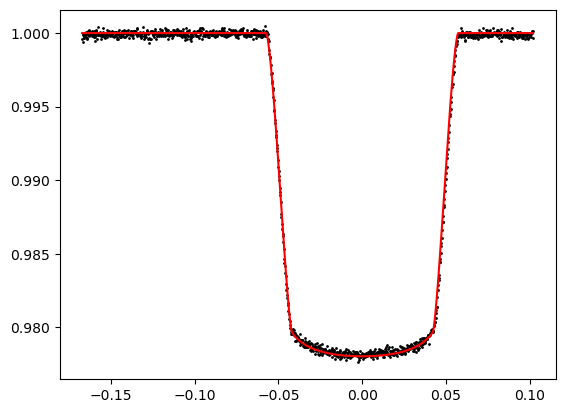

In [4]:
df = pd.read_csv('Sing_2024_Fig1_WASP107b_white_light_curve_data.csv')
t = jnp.array(df['bjd_tdb(days)']-2460118.948861)
#f = df['NRS1_wlc_flux']
f = jnp.array(df['NRS2_wlc_flux'])
yerr = jnp.array(df['NRS2_wlc_flux_err'])
plt.scatter(t,f,c='k',s=1)
plt.plot(t,oblate_lightcurve(init_params, t),c='r')

In [5]:
def model(t, yerr, y=None):
    # If we wanted to fit for all the parameters, we could use the following,
    # but we'll keep these fixed for simplicity.
    
    #log_duration = numpyro.sample("log_duration", dist.Uniform(jnp.log(0.08), jnp.log(0.2)))
    #b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    #log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(yerr), 1.0))
    r_circ = numpyro.sample("r_circ", dist.Uniform(0.01, 0.2))
    u = numpyro.sample("u", distx.QuadLDParams())
    bo = numpyro.sample("bo", dist.Uniform(0.0,1.))
    
    #parametrize f, theta using a unit disk
    hk = numpyro.sample("hk", distx.UnitDisk())
    f = numpyro.deterministic("f", (hk[0] ** 2 + hk[1] ** 2)/2)
    theta = numpyro.deterministic("theta", jnp.arctan2(hk[1], hk[0])/2)
    
    # The duration
    log_d = numpyro.sample("log_d", numpyro.distributions.Normal(jnp.log(init_params['duration']), 0.01))
    duration = numpyro.deterministic("duration", jnp.exp(log_d))
    t0 = numpyro.sample("t0", dist.Uniform(-0.0001, 0.0001))
    params = {
        'period':init_params['period'],
        't0': t0,
        "radius": jnp.sqrt(r_circ**2/(1-f)),
        'bo':bo,
        'u': u,
        'f':f, 
        'theta':theta,
        'duration': duration
    }
    y_pred = oblate_lightcurve(params, t)
    numpyro.deterministic("light_curve", y_pred)
    numpyro.sample(
        "flux",
        dist.Normal(y_pred, jnp.sqrt(yerr**2) #+ jnp.exp(2 * log_jitter))
                    ),
        obs=y,
    )

In [6]:
import numpyro_ext.distributions, numpyro_ext.optim


run_optim = numpyro_ext.optim.optimize(
        model,
        init_strategy=numpyro.infer.init_to_value(values=init_params),
        return_info=True
    )

opt_params, status = run_optim(jax.random.PRNGKey(10), t, yerr, y=f)

In [7]:
opt_params

{'r_circ': Array(0.14411448, dtype=float64),
 'u': Array([0.07794649, 0.14130726], dtype=float64),
 'bo': Array(0.09529518, dtype=float64),
 'hk': Array([ 0.05001373, -0.34298993], dtype=float64),
 'log_d': Array(-2.16229487, dtype=float64),
 't0': Array(3.02521586e-05, dtype=float64),
 'duration': Array(0.11506077, dtype=float64),
 'f': Array(0.06007173, dtype=float64),
 'flux': Array([0.99957961, 0.99941671, 0.99995651, ..., 1.00006389, 1.00013725,
        0.99963939], dtype=float64),
 'light_curve': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64),
 'theta': Array(-0.71299996, dtype=float64)}

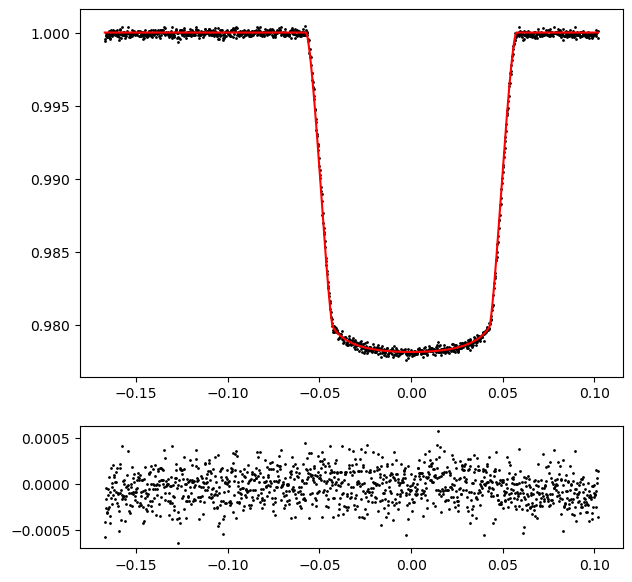

In [8]:
opt_params['radius'] = np.sqrt(opt_params['r_circ']**2/(1-opt_params['f']))
opt_params['period'] = 5.7214742
fig, (ax, ax1) = plt.subplots(2,1,figsize=(7,7), gridspec_kw={'height_ratios': [3, 1]})
ax.scatter(t,f,c='k',s=1)
ax.plot(t,oblate_lightcurve(opt_params, t),c='r')
ax1 = plt.scatter(t, f-oblate_lightcurve(opt_params, t), c='k', s=1)

In [9]:
jnp.std(f-oblate_lightcurve(opt_params, t))*1e6

Array(177.28860992, dtype=float64)

In [10]:
sampler_wn = infer.MCMC(
    infer.NUTS(
        model,
        target_accept_prob=0.8,
        dense_mass=True,
        init_strategy=infer.init_to_value(values=opt_params),
        regularize_mass_matrix=False,
        max_tree_depth=5
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), t, yerr, f)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 2h 45min 39s, sys: 36.6 s, total: 2h 46min 15s
Wall time: 1h 24min 42s


In [11]:
inf_data_wn = az.from_numpyro(sampler_wn)
az.summary(inf_data_wn, var_names=['r_circ', 'bo', 'u', 'f', 'theta', 'duration'])

/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r_circ,0.144,0.000,0.144,0.144,0.000,0.000,508.0,942.0,1.00
bo,0.094,0.047,0.000,0.168,0.004,0.003,146.0,70.0,1.00
u[0],0.078,0.010,0.060,0.096,0.000,0.000,629.0,815.0,1.00
u[1],0.142,0.022,0.101,0.181,0.001,0.001,617.0,1014.0,1.00
f,0.050,0.043,0.000,0.127,0.003,0.002,349.0,171.0,1.00
theta,-0.574,0.581,-1.512,0.603,0.036,0.025,265.0,384.0,1.01
duration,0.115,0.000,0.115,0.116,0.000,0.000,303.0,186.0,1.00


In [12]:
inf_data_wn.to_netcdf("wasp107_NIRISS2_NUTS.h5")

'wasp107_NIRISS2_NUTS.h5'

/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<AxesSubplot:title={'center':'r_circ'}>,
        <AxesSubplot:title={'center':'r_circ'}>],
       [<AxesSubplot:title={'center':'bo'}>,
        <AxesSubplot:title={'center':'bo'}>],
       [<AxesSubplot:title={'center':'u'}>,
        <AxesSubplot:title={'center':'u'}>],
       [<AxesSubplot:title={'center':'hk'}>,
        <AxesSubplot:title={'center':'hk'}>],
       [<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'duration'}>]], dtype=object)

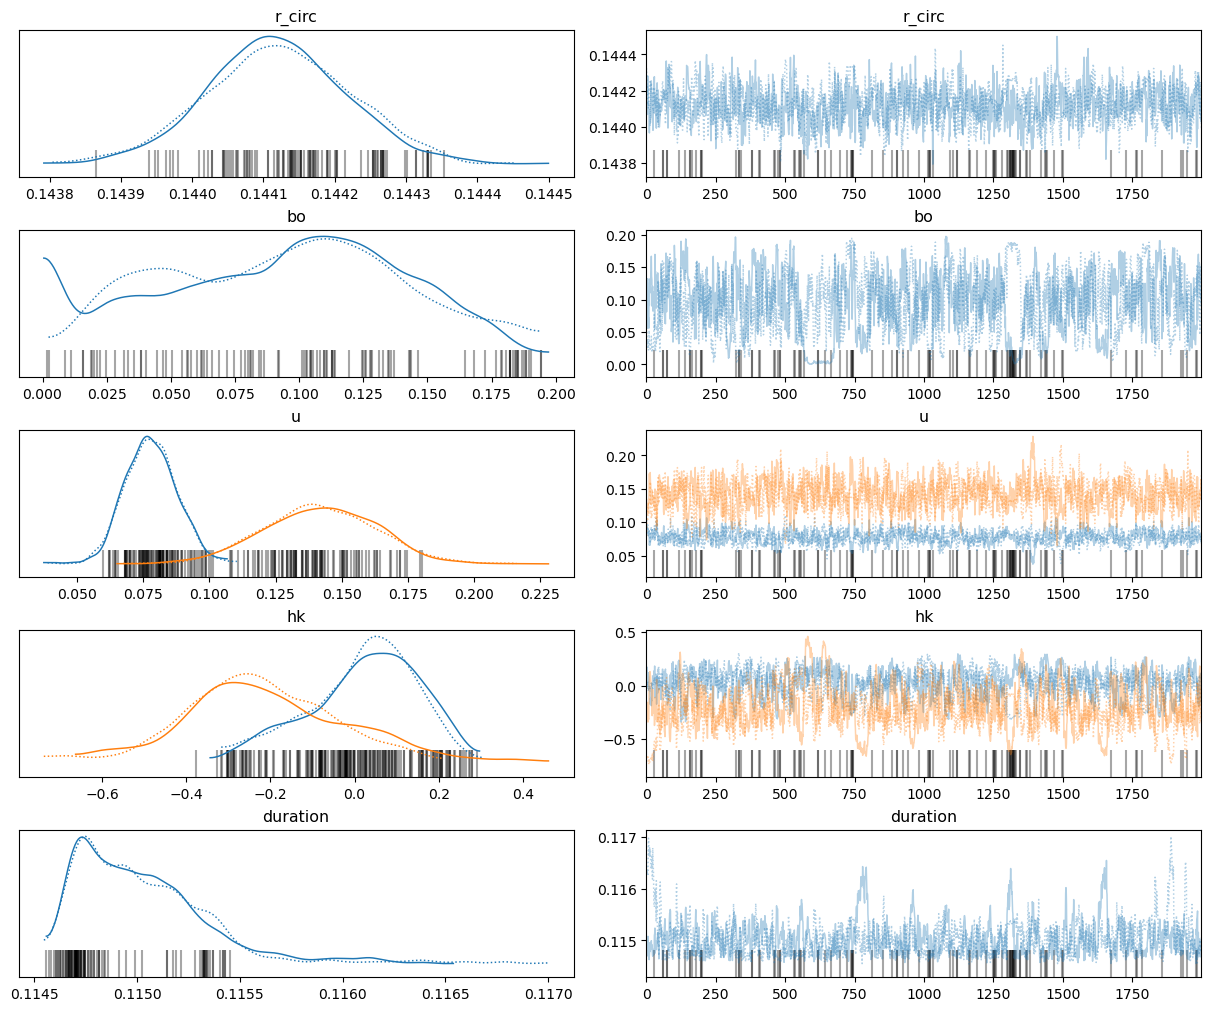

In [13]:
az.plot_trace(
    inf_data_wn,
    var_names=['r_circ', 'bo', 'u', 'hk', 'duration'],
    backend_kwargs={"constrained_layout": True},
)

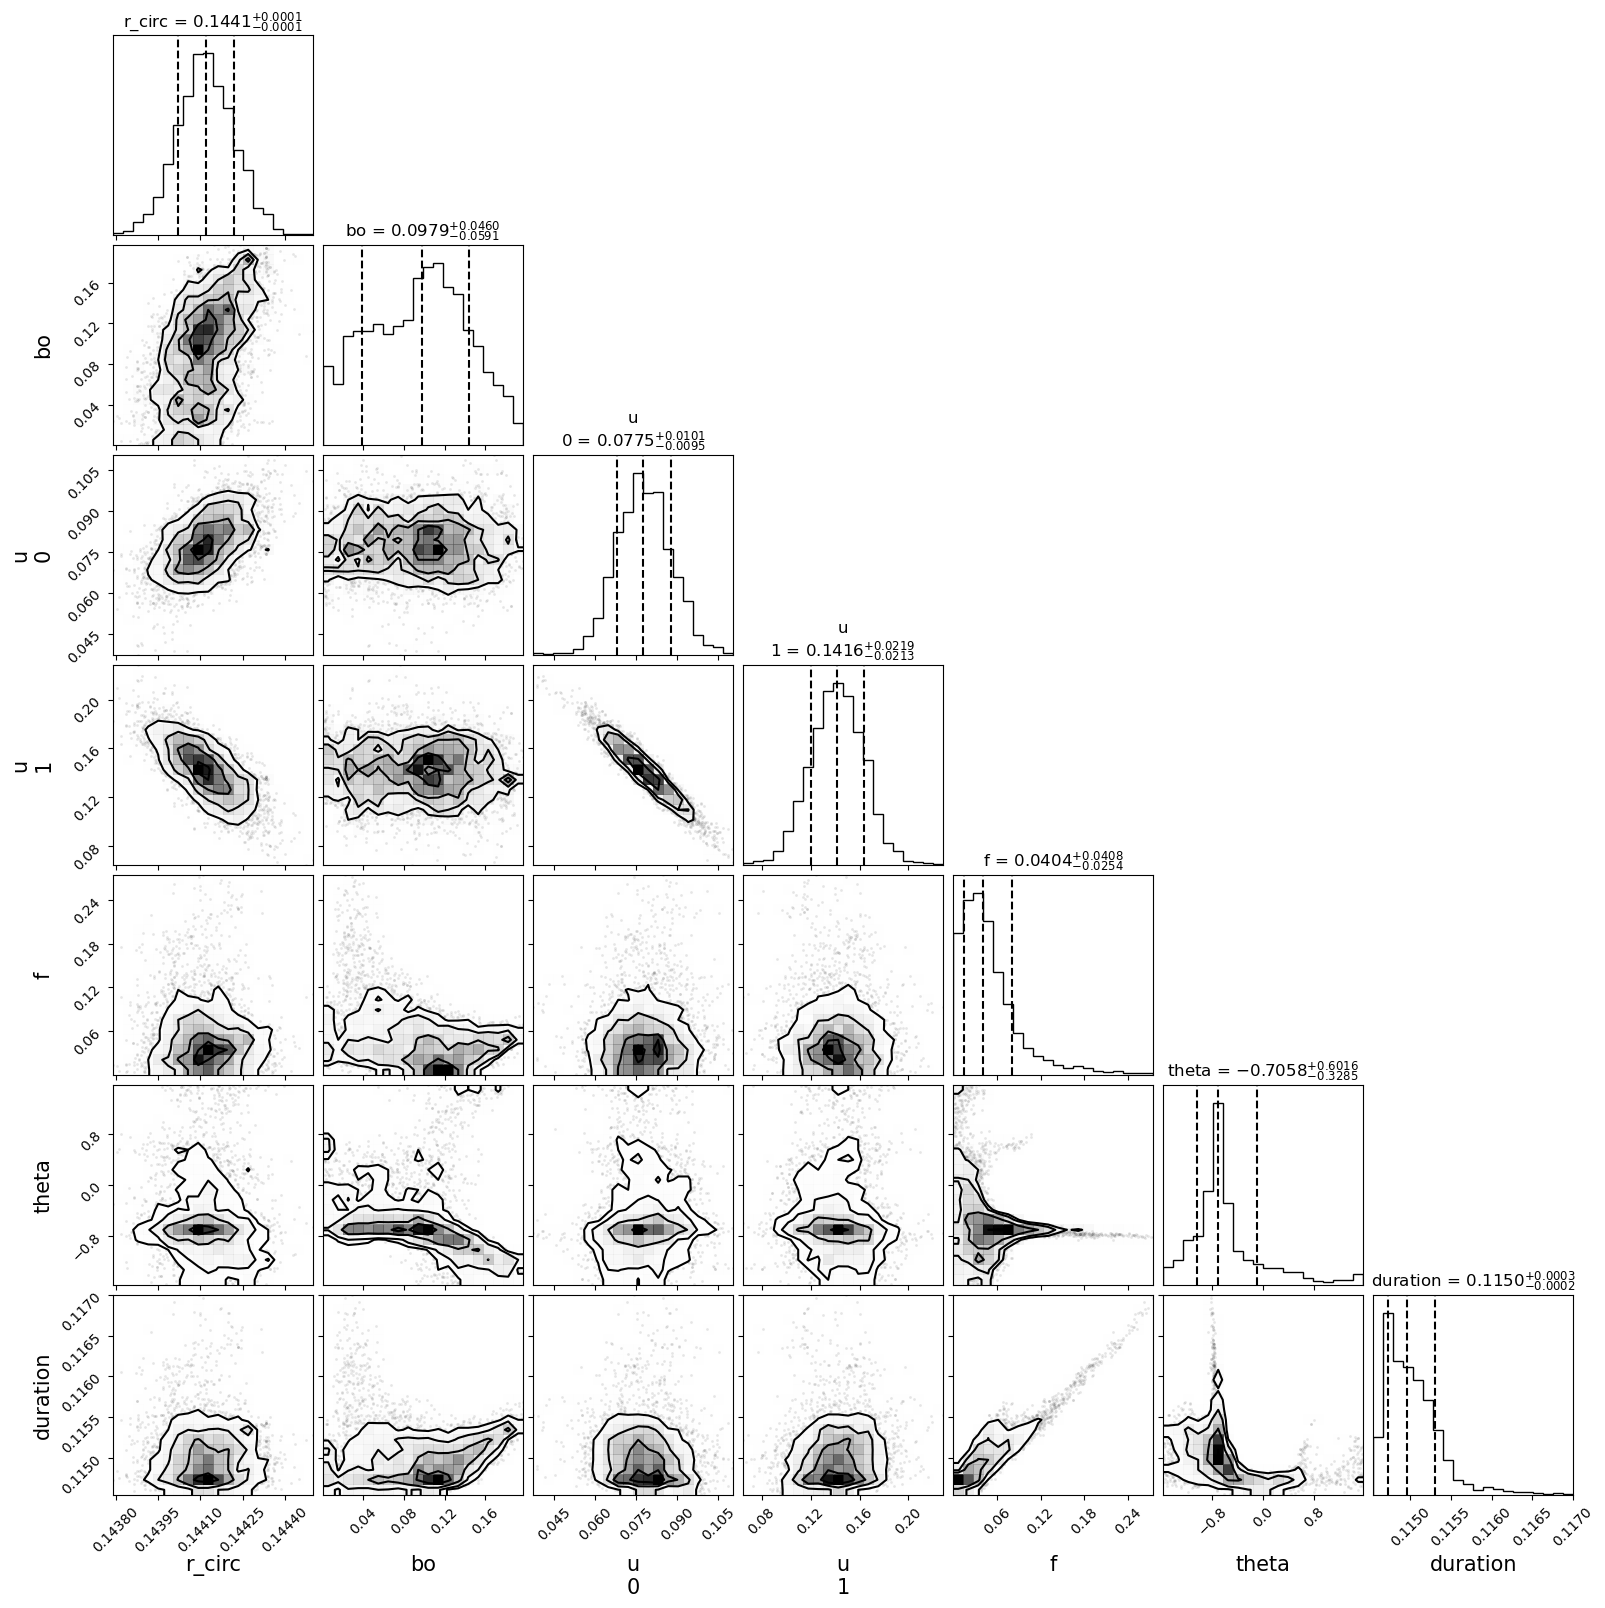

In [20]:
corner.corner(
    inf_data_wn,
    var_names=['r_circ', 'bo', 'u', 'f','theta', 'duration'],
    #truths=[np.sqrt(true_params['radius']**2*(1-true_params['f'])), true_params['bo'], true_params['u'][0], true_params['u'][1], true_params['f'], true_params['theta'], true_params['duration']],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 15},
    title_fmt=".4f",
);
#plt.savefig("wasp107_niriss2_corner_hk.png",dpi=300)

In [17]:
sampler_wn.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        bo      0.09      0.05      0.10      0.02      0.17    173.33      1.00
     hk[0]      0.02      0.13      0.04     -0.21      0.23    236.24      1.01
     hk[1]     -0.22      0.19     -0.23     -0.51      0.12    203.72      1.01
     log_d     -2.16      0.00     -2.16     -2.17     -2.16    216.87      1.00
    r_circ      0.14      0.00      0.14      0.14      0.14    507.14      1.00
        t0      0.00      0.00      0.00     -0.00      0.00    663.71      1.00
      u[0]      0.08      0.01      0.08      0.06      0.09    615.07      1.00
      u[1]      0.14      0.02      0.14      0.11      0.18    611.33      1.00

Number of divergences: 109


In [49]:
sample_inds = np.random.choice(np.concatenate(inf_data_wn.posterior.light_curve.values, axis=0).shape[0], 30, replace=False)
sample_lcs = np.concatenate(inf_data_wn.posterior.light_curve.values, axis=0)[sample_inds]

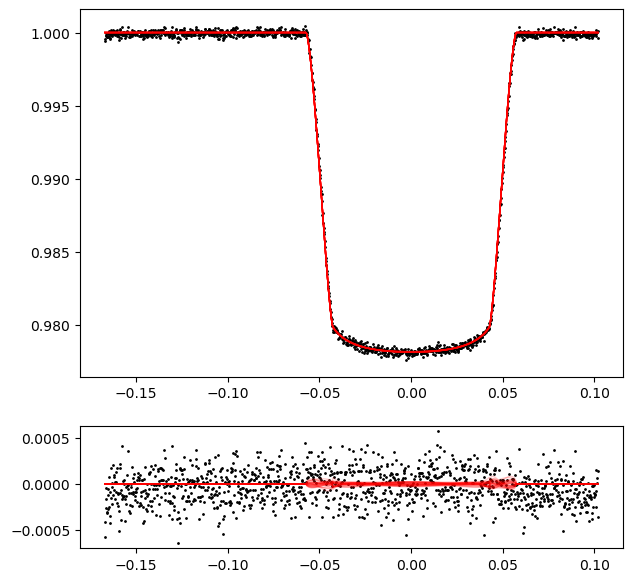

In [50]:
fig, (ax, ax1) = plt.subplots(2,1,figsize=(7,7), gridspec_kw={'height_ratios': [3, 1]})
ax.scatter(t,f,c='k',s=1)
ax.plot(t,inf_data_wn.posterior.light_curve.mean(dim=('chain','draw')),c='r',lw=1)
for lc in sample_lcs:
    ax.plot(t, lc, c='r', alpha=0.2, lw=1)
    ax1.plot(t, inf_data_wn.posterior.light_curve.mean(dim=('chain','draw'))-lc, c='r', alpha=0.2, lw=1)
ax1 = plt.scatter(t, f-inf_data_wn.posterior.light_curve.mean(dim=('chain','draw')), c='k', s=1)
plt.savefig("wasp107_niriss2_lc.png",dpi=300)